In [2]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path

# vizualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

# GIS
import fiona
import fiona.crs
import shapely
import rasterio
import rasterio.plot
import rasterio.mask
import geopandas as gpd

os.chdir("/home/lune/Code/ai4er/mres")
from src.loading import Load
import src.plots as plots
from src.mycolors import rand_cmap
from src.treechange import TreeChange,SegmentationRun
import src.utils as utils


In [3]:
 %matplotlib inline

In [4]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as fc

In [5]:
#%%
try:
    dirpath = Path(os.path.dirname(__file__))
except:
    dirpath = Path(os.getcwd())/"development_python"

# dir_data = Path(f"{dirpath}/../Data/lidar/danum")
dir_data = Path(f"{dirpath}/../Data/lidar/danum")
os.getcwd()

'/home/lune/Code/ai4er/mres'

In [6]:
tc =TreeChange(dir_data,(2013,2014))
tc.gather_all_runs()
tc.load_rasters(create_diff=True)
tc.print()

Index of runs computed.
Tree Comparison Object
Data (dir_data):	/home/lune/Data/ai4er/mres/lidar/danum
Years:	Pair(old=2013, new=2014)
Rasters:
	old: rasters/raster2013.tif
	new: rasters/raster2014.tif
	diff: rasters/diff.tif
Available runs:
	file: index.txt
	Number: 285
	WS: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
	    [13, 17, 19, 17, 16, 117, 22, 8, 23, 21, 12]
Runs loaded:
	Number: 0



In [13]:
rn = tc.load_run(319,load_rast=[],load_nn=False)
rn.print()

Run 319 already loaded.
Parameters loaded:
	ws      18.000000
	seed     0.405772
	cr       0.791667
	max     41.773990
	Name: 319, dtype: float64
Dataframe:
	Polygon interiors: No
	Rows:	 2510
	Columns:	 7
		['geometry', 'area', 'diff_img', 'missing_pixels', 'is_missing', 'old_img', 'new_img']



In [14]:
rn.find_missing_trees(pixel_ratio=0.1);
rn.print()

Parameters loaded:
	ws      18.000000
	seed     0.405772
	cr       0.791667
	max     41.773990
	Name: 319, dtype: float64
Dataframe:
	Polygon interiors: No
	Rows:	 2510
	Columns:	 7
		['geometry', 'area', 'diff_img', 'missing_pixels', 'is_missing', 'old_img', 'new_img']



In [12]:
rn.generate_tree_rasters(['all'])
rn.print()

Parameters loaded:
	ws      18.000000
	seed     0.405772
	cr       0.791667
	max     41.773990
	Name: 319, dtype: float64
Dataframe:
	Polygon interiors: No
	Rows:	 2510
	Columns:	 7
		['geometry', 'area', 'diff_img', 'missing_pixels', 'is_missing', 'old_img', 'new_img']



In [18]:
rn.match_trees()
rn.df.head()

,geometry,area,diff_img,missing_pixels,is_missing,old_img,new_img,nn,nn2,diff,i_diff
treeID,,,,,,,,,,,
23,"POLYGON ((588123.500 548713.500, 588123.500 54...",5.75,"[[-1.3432693481445312, -1.3192138671875, -1.05...",0,False,"[[34.418518, 34.4288, 34.447, 34.526047, 34.91...","[[35.761787, 35.748013, 35.501945, 35.65549, 3...",0.500000,24.041631,23.541631,True
19,"POLYGON ((588548.000 548713.500, 588548.000 54...",4.00,"[[-0.5269851684570312, -0.65765380859375, -0.1...",0,False,"[[23.348051, 30.742346, 31.235691, 32.21084, 3...","[[23.875036, 31.4, 31.432169, 31.891615, 32.19...",4.609772,10.012492,5.402720,False
5,"POLYGON ((587595.000 548713.500, 587595.000 54...",9.00,"[[3.525562286376953, 17.087745666503906, 5.283...",1,False,"[[54.367714, 63.386387, 66.71, 66.71, 65.22761...","[[50.84215, 46.29864, 61.42614, 61.185715, 61....",1.118034,24.758837,23.640803,True
20,"POLYGON ((587206.000 548713.500, 587206.000 54...",66.00,"[[2.4854488372802734, -0.23720550537109375, -0...",0,False,"[[31.810867, 32.95396, 34.41595, 36.563026, 41...","[[29.325418, 33.191166, 35.17459, 41.624, 41.7...",13.601471,24.758837,11.157366,True
25,"POLYGON ((588221.000 548713.500, 588221.000 54...",37.25,"[[-0.11693572998046875, -0.05290985107421875, ...",0,False,"[[64.07909, 63.985214, 63.891346, 63.795586, 6...","[[64.19602, 64.038124, 64.798546, 65.20135, 65...",5.522681,24.520400,18.997719,True


(587149.0, 587584.15, 548413.8, 548714.0)

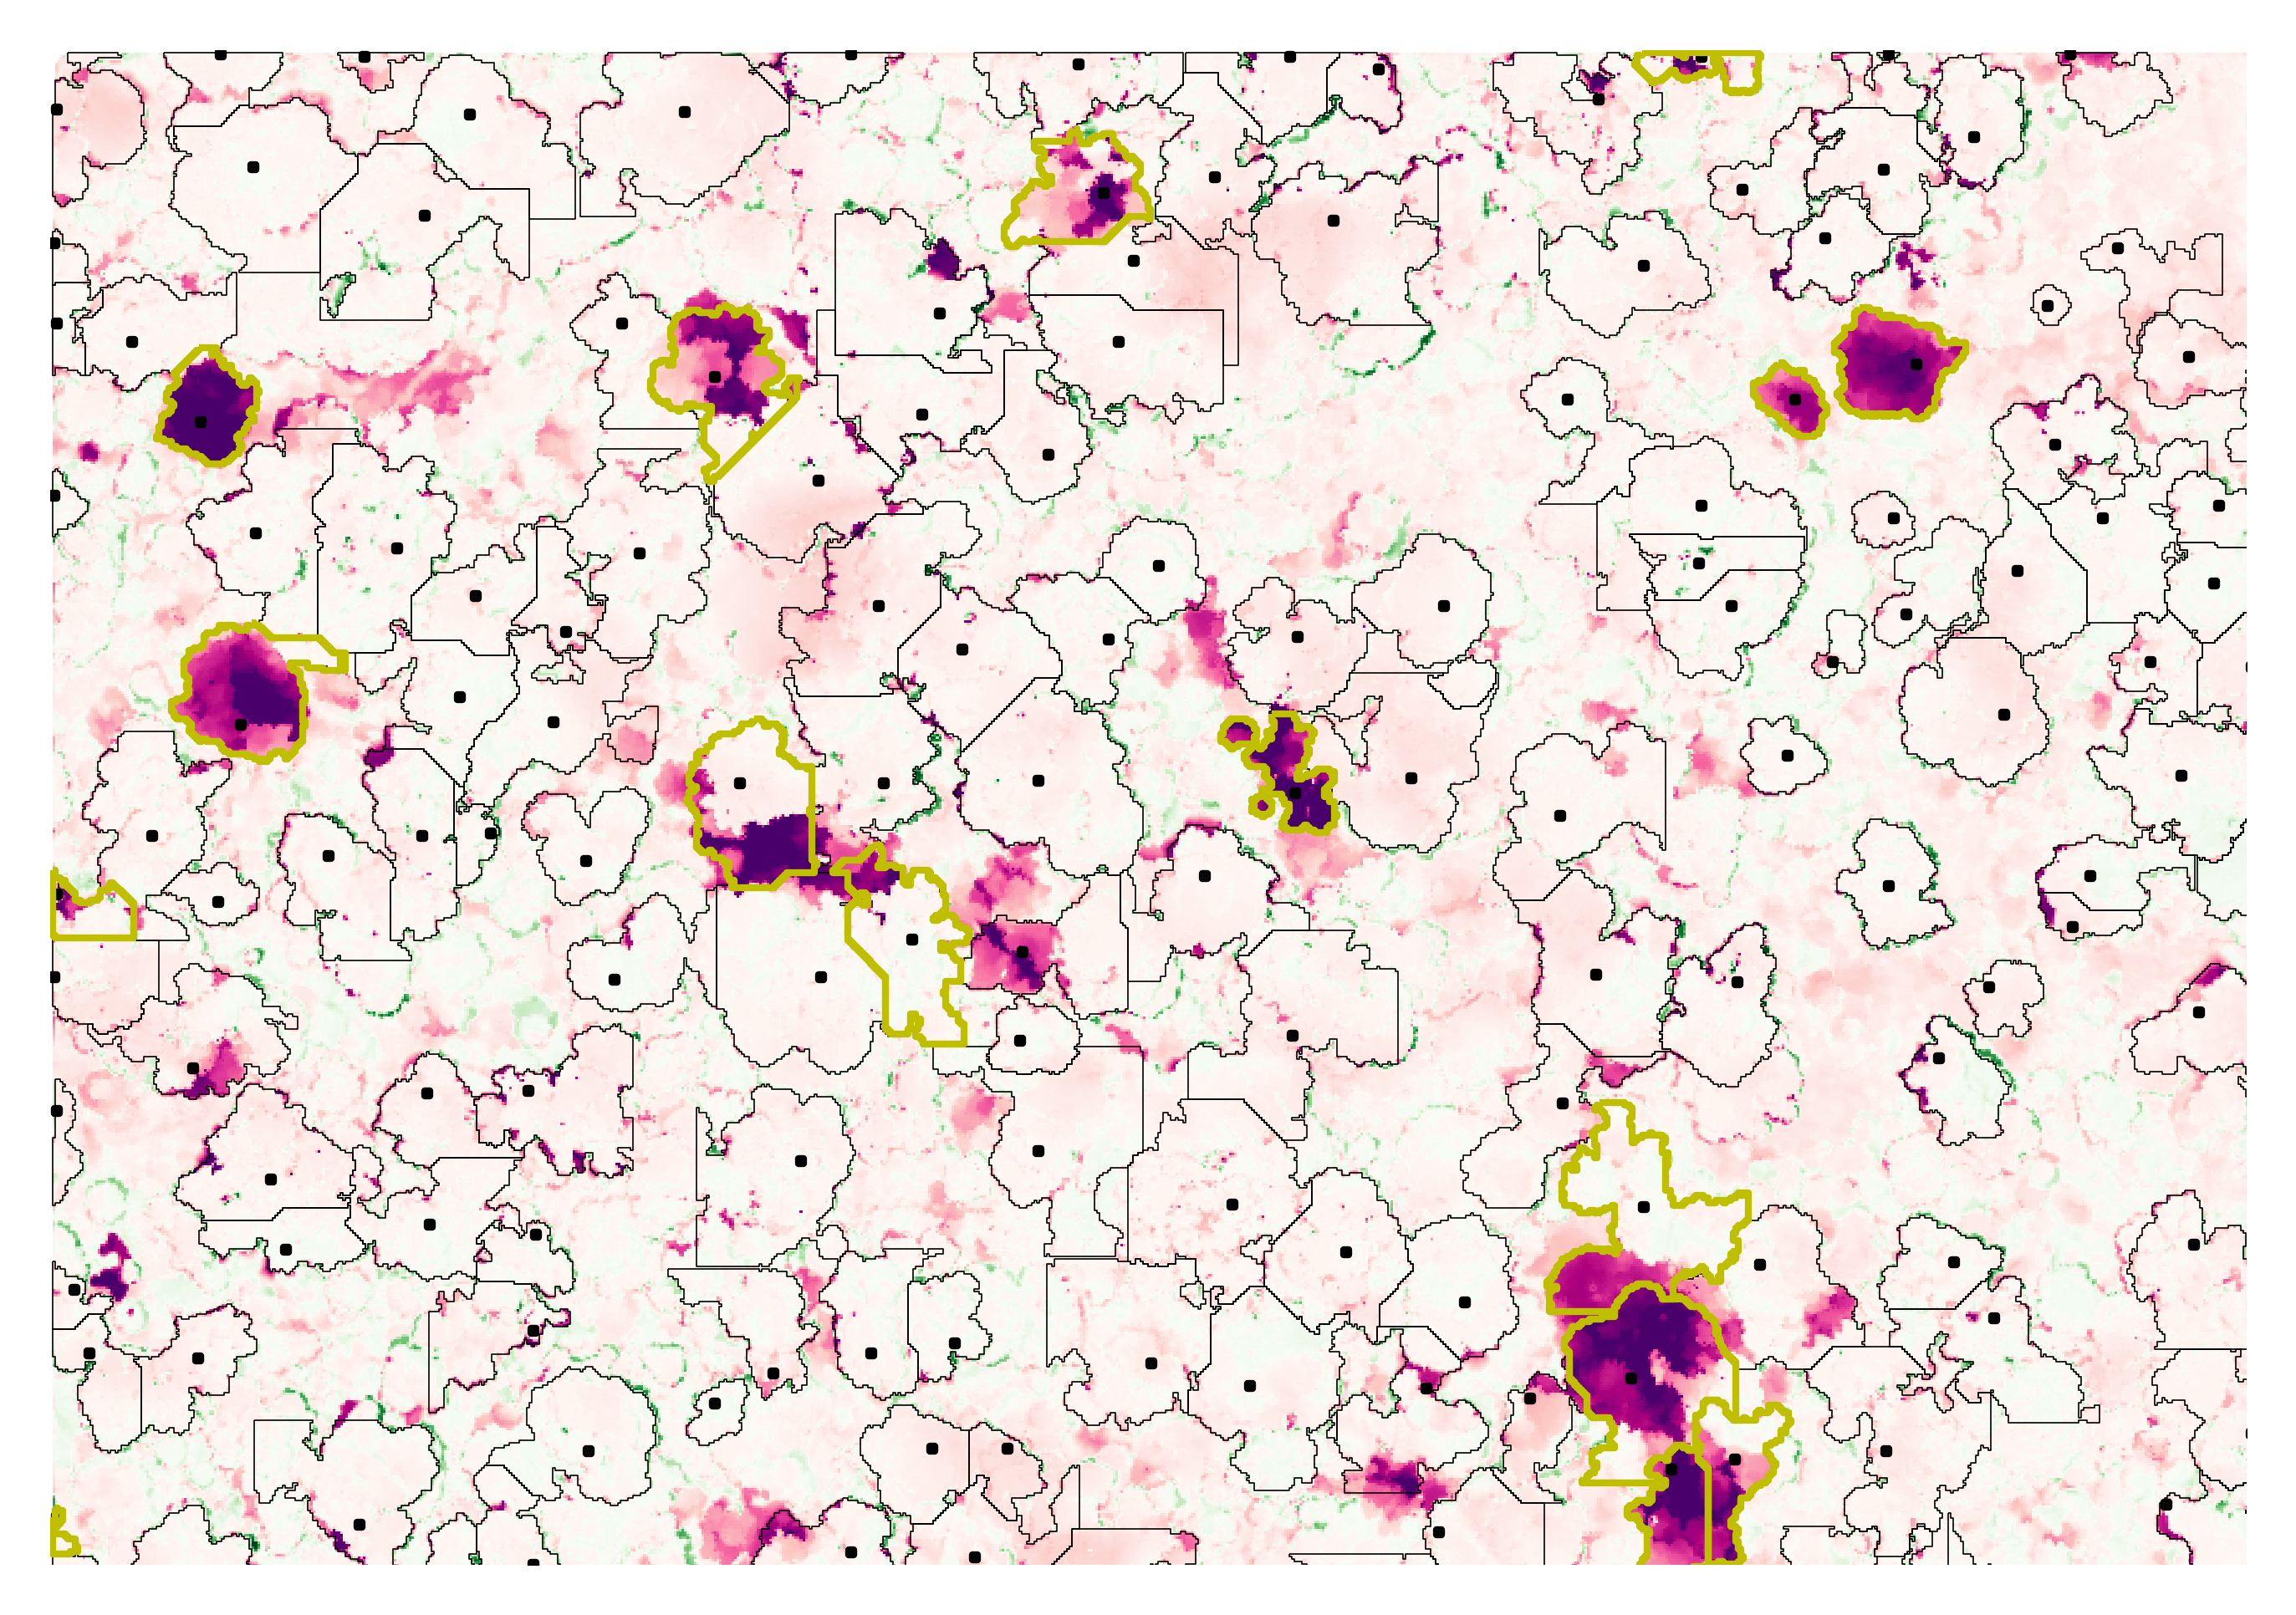

In [19]:
extent_full = shapely.geometry.box(*tc.chm.old.bounds)
xmin,ymin,xmax,ymax =extent_full.bounds
cropx = (0.0,0.3)
cropy = (0.8,1)
xmin,ymin,xmax,ymax =utils.crop(extent_full.bounds,(*cropx,*cropy))



fig,ax = plt.subplots(dpi=600)
colm=plots.color_mapping_diff
plots.plot_raster(tc.diff,ax=ax,cmap=colm.cmap,norm=colm.norm)

rn._tt.old.plot(marker=',',markersize=0.5,color='k',ax=ax)

polygon_par = dict()
rn.df.geometry.exterior.plot(ax=ax,color='k',
                                      linewidth=0.2,
                                      **polygon_par)
rn.df[rn.df.is_missing].exterior.plot(ax=ax,color='y',
                                      linewidth=1,
                                      **polygon_par)

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.axis("off")

In [22]:
rn = tc.load_run_random()
rn.print()

Parameters loaded:
	ws      17.000000
	seed     0.368169
	cr       0.733370
	max     50.640120
	Name: 271, dtype: float64
Dataframe:
	Polygon interiors: No
	Rows:	 2702
	Columns:	 7
		['geometry', 'area', 'nn', 'nn2', 'diff', 'i_diff', 'old_img']



In [23]:
def gather_values(rn):
    s = pd.Series()
    s["misspx_10"] = rn.find_missing_trees(pixel_ratio=0.10).sum()
    s["missar_10"] = rn.df["area"][rn.df["is_missing"]].sum()
    s["misspx_15"] = rn.find_missing_trees(pixel_ratio=0.15).sum()
    s["missar_15"] = rn.df["area"][rn.df["is_missing"]].sum()
    s["misspx_20"] = rn.find_missing_trees(pixel_ratio=0.20).sum()
    s["missar_20"] = rn.df["area"][rn.df["is_missing"]].sum()
    s["total_trees"] = rn.df.shape[0]
    s["area_total"] = rn.df["area"].sum()
    s["area_mean"] = rn.df['area'].mean()
    s["area_median"] = rn.df['area'].median()
    return s

In [26]:
val = gather_values(rn)

extent_full = shapely.geometry.box(*tc.chm.old.bounds)
area=extent_full.area/1000000


<ipython-input-23-045c54375490>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


In [27]:
print(f"'misspx_10': {val['misspx_10']/val['total_trees']}")
print(f"'misspx_15': {val['misspx_15']/val['total_trees']}")
print(f"'misspx_20': {val['misspx_20']/val['total_trees']}")
print(f"'total_trees': {val['total_trees']/area}")
print(f"'missar_10': {val['missar_10']/val['area_total']}")
print(f"'missar_15': {val['missar_15']/val['area_total']}")
print(f"'missar_20': {val['missar_20']/val['area_total']}")
print(f"'area_total': {val['area_total']/area}")
print(f"'area_mean': {val['area_mean']}")
print(f"'area_median': {val['area_median']}")



'misspx_10': 0.02701702442635085
'misspx_15': 0.02072538860103627
'misspx_20': 0.017394522575869726
'total_trees': 1241.0432571552321
'missar_10': 0.015252306310470393
'missar_15': 0.010958450110593168
'missar_20': 0.008858907206854208
'area_total': 621564.5963704307
'area_mean': 500.84039600296074
'area_median': 476.25


In [28]:
tc.print()


Tree Comparison Object
Data (dir_data):	/home/lune/Data/ai4er/mres/lidar/danum
Years:	Pair(old=2013, new=2014)
Rasters:
	old: rasters/raster2013.tif
	new: rasters/raster2014.tif
	diff: rasters/diff.tif
Available runs:
	file: index.txt
	Number: 285
	WS: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
	    [13, 17, 19, 17, 16, 117, 22, 8, 23, 21, 12]
Runs loaded:
	Number: 3
	(run samples only)
	Run 61
		Parameters loaded:
			ws      20.000000
			seed     0.218605
			cr       0.644029
			max     45.004020
			Name: 61, dtype: float64
		Dataframe:
			Polygon interiors: No
			Rows:	 2168
			Columns:	 7
				['geometry', 'area', 'nn', 'nn2', 'diff', 'i_diff', 'old_img']
	Run 271
		Parameters loaded:
			ws      17.000000
			seed     0.368169
			cr       0.733370
			max     50.640120
			Name: 271, dtype: float64
		Dataframe:
			Polygon interiors: No
			Rows:	 2702
			Columns:	 10
				['geometry', 'area', 'nn', 'nn2', 'diff', 'i_diff', 'old_img', 'diff_img', 'missing_pixels', 'is_missing']

